# Utilizing RAS-Commander for HEC-RAS Automation 

In this portion of the workshop we will use LLM's to use the new RAS-Commander Library to directly test the Manning's n function that we created in the first hour of the workshop.  




Workshop users can either download the full repository:  
[RAS-Commander Github Repository](https://github.com/gpt-cmdr/ras-commander/tree/main)  

![Download RAS-Commander Repository](images/rascmdr-downloadrepo.png)  

Or download the an LLM knowledge base for RAS-Commander and utilize Google AI Studio:  
[RAS-Commander API Reference Markdown File](https://github.com/gpt-cmdr/ras-commander/tree/main/ai_tools/llm_knowledge_bases) 

Due to the size of the code base, your LLM may not be able to handle the full repositorys contents.  


**ras-commander_fullrepo.txt** _~950k Tokens_ - All contents of the repository, all functions, cleaned notebooks, and documentation

**ras_commander_documentation_only.txt** _~188k Tokens_ - Repository Documntation, without Code.  

**ras_commander_classes_and_functions_only.txt** _~137k Tokens_ - Includes just the code.  Combine this with an example notebook in Claude or ChatGPT's o1/o3 model to ask questions and request revisions or additions

**ras_commander_ras_functions_only.txt** _~80k tokens_ - Includes only the code for RAS automation functions

ras_commander_hdf_functions_only.txt 90k** _~89k tokens_ - Includes only the code for HDF data access


## How to Leverage LLM's with RAS-Commander

- [RAS-Commander GPT](https://chatgpt.com/g/g-TZRPR3oAO-ras-commander-library-assistant)
    Similar to the GPT's we have built in this class, this GPT has access to the RAS-Commander codebase and documentation, and can perform limited operations using ChatGPT's Code Interpreter.  2 Example projects are included. 

- [API Documentation](https://github.com/gpt-cmdr/ras-commander/blob/main/api.md)(shown above)
    This document provides the minimum documentation needed for an LLM to translate your plain language commands to a series of python function calls that interact with HEC-RAS Files.

    
- Not covered in this course:

    - [Detailed Knowledge Bases](https://github.com/gpt-cmdr/ras-commander/tree/main/ai_tools/llm_knowledge_bases)  
    These knowledge bases comprise of various combinations of plain text files from the repository to provide more comprehensive context.  These are suitable for more advanced development where you want the LLM to see the underlying logic to create new functions or develop new features. 

    - [Cursor IDE Integration](https://github.com/gpt-cmdr/ras-commander/blob/main/.cursorrules)
        For users that have the AI-powered VS Code Fork Cursor, there is a .cursorrules file included in the repository that automatically loads system instructions when making requests


    - [RAS-Commander Library Assistant](https://github.com/gpt-cmdr/ras-commander/tree/main/ai_tools/library_assistant)
        For users that want to use RAS-Commander with a pay-as-you-go API key from OpenAI, Anthropic, or other providers.  


## Using the RAS-Commander GPT Assistant

Before starting on our notebook, use the GPT Assistant to explore our files 


![RAS-Commander GPT Assistant Exporatory Prompts](images/rascmdr_gpt_defaults.png)


The GPT has a copy of the results from 2 HEC-RAS Example Projects (Bald Eagle Creek and the Pipes Beta project).  However GPT's are not yet reliable enough for heavy lifting with the library.  

Workshop users are invited to take 2-3 minutes to upload the `RAS_Muncie.p04.hdf` file and ask for a summary of project information and request geometric data or time series results.  These requests may or not be successful, and we will continue with oher methods to improve responses and perform the Manning's N automation. 

-----

## Proposed Workflow Description

Here we will describe the workflow that will be required to implement and test the Manning's N Base Overrides and Regional Override functions, using the HEC-RAS Example Project "BaldEagleCrkMulti2D", which has the project name "BaldEagleDamBrk"

### Detailed Workflow

    1. Create "RAS-Commander Test" subfolder in the same directory as this notebook, then extract "BaldEagleMulti2D"
    2. List all project dataframes for the user's review
    3. Existing Plan 06 uses Geometry 09.  Both of these will need to be cloned and the new plan will need to have the new geomery set as the active geometry
    4. In the new plan and geometry, revise the Plan Name, ShortID and Description to denote that all roughness tables are increased by 0.01
    5. Using the functions below, revise all base and region overrides in the new plan
    6. Run both plans, parallel, 2 cores apiece
    7. Using the point (2081626, 366459), find the nearest mesh cell and compare the results for the Template and Revised Plan.  Create a plot showing water surface elevation a the closest mesh cell. 

Work step by step through the notebook, including Markdown cells that explain each RAS-Commander function, its arguments, and how we are using it in our notebook.  Clearly explain the notebook's operation and show all work to maintain transparent operation.  

Favor simple and concise code, and short segments of code that are easy to understand, to allow the user to observe each step.  



-----

## Reference Functions from Previous Notebook

The following function is from a previous notebook, it is tested and works. 



In [1]:
# Manning's N Override Functions to use in this notebook. 
import pandas as pd
from pathlib import Path





# === Parsing functions ===
def parse_lcmann_table(lines):
    table_data = []
    current_table_number = None

    for i, line in enumerate(lines):
        if line.startswith("LCMann Table="):
            current_table_number = line.split("=")[-1].strip()
            j = i + 1
            while j < len(lines):
                next_line = lines[j].strip()
                if next_line.startswith("LCMann") or not next_line or "=" in next_line:
                    break
                if ',' in next_line:
                    try:
                        land_cover, n_val = next_line.rsplit(",", 1)
                        table_data.append([current_table_number, land_cover.strip(), float(n_val.strip())])
                    except ValueError:
                        pass
                j += 1
            break

    return pd.DataFrame(table_data, columns=["Table", "Land Cover Type", "n"])

def parse_lcmann_region_table(lines):
    table_data = []
    current_table_number = None

    for i, line in enumerate(lines):
        if line.startswith("LCMann Region Table="):
            current_table_number = line.split("=")[-1].strip()
            j = i + 1
            while j < len(lines):
                next_line = lines[j].strip()
                if next_line.startswith("LCMann") or not next_line or "=" in next_line:
                    break
                if ',' in next_line:
                    try:
                        land_cover, n_val = next_line.rsplit(",", 1)
                        table_data.append([current_table_number, land_cover.strip(), float(n_val.strip())])
                    except ValueError:
                        pass
                j += 1
            break

    return pd.DataFrame(table_data, columns=["Table", "Land Cover Type", "n"])


Example Usage from Previous Notebook

The function is included above, and all code that was specific to the previous notebook is placed here for reference: 
```
## === User-defined file paths ===
input_file = Path(r"C:\GH\ASFPM-LLM-Data-Management-Workshop\Data\Ascii\RAS_BaldEagleDamBrk.g09")
output_lcmann_csv = "LCMann_Table.csv"
output_lcmann_region_csv = "LCMann_Region_Table.csv"

## === Read geometry file ===
with open(input_file, "r", encoding="utf-8", errors="ignore") as file:
    lines = file.readlines()

## === Parse both tables ===
lcmann_df = parse_lcmann_table(lines)
lcmann_region_df = parse_lcmann_region_table(lines)

## Display both tables
print("LCMann Table:")
display(lcmann_df)
print("\nLCMann Region Table:")
display(lcmann_region_df)

## === Export to CSV ===
lcmann_df.to_csv(output_lcmann_csv, index=False)
lcmann_region_df.to_csv(output_lcmann_region_csv, index=False)

print(f"Saved LCMann Table to: {output_lcmann_csv}")
print(f"Saved LCMann Region Table to: {output_lcmann_region_csv}")
```

In [2]:
def write_lcmann_table(df, lines):
    new_lines = lines.copy()
    for i, line in enumerate(lines):
        if line.startswith("LCMann Table="):
            j = i + 1
            while j < len(lines):
                current = lines[j].strip()
                if current.startswith("LCMann") or not current or "=" in current:
                    break
                j += 1
            # Replace the block between i+1 and j with updated lines
            updated_block = [f"{row['Land Cover Type']},{row['n']:.3f}\n" for _, row in df.iterrows()]
            new_lines[i+1:j] = updated_block
            break
    return new_lines

# NOTE: We don't need LCMann Region Tables (they do not exist in this geometry)

Example Usage from Previous Notebook

The function is included above, and all code that was specific to the previous notebook is placed here for reference: 
```
# 🧪 Example: increase all 'n' values by 0.02
lcmann_df['n'] += 0.002
print("Revised LCMann Table:")
display(lcmann_df)

# 🛠 Update the file content
updated_lines = write_lcmann_table(lcmann_df, lines)

# 💾 Write updated geometry back to disk (overwrite or save as new)
output_file = Path(r"RAS_BaldEagleDamBrk_MODIFIED.g09")
with open(output_file, "w", encoding="utf-8") as f:
    f.writelines(updated_lines)

print(f"Updated geometry file saved to: {output_file}")
```

-----

# RAS-Commander Installation and Import

In [3]:


# If you haven't installed ras-commander, remove the leading # on the next line:
#!pip install --upgrade ras-commander

# Import all functions and classes from ras-commander
from ras_commander import *

In [4]:
# All Other Imports (consolidate all imports here)
import os
import shutil

# Project Setup 

All outputs of this notebook should be placed in the subfolder "RAS-Commander Mannings Sensitivity Test".  

If the folder exists, delete it.  Otherwise, create it.  This will make our notebook repeatable. 

This folder should be sensitivity_folder and should be set as the current working direcory to simplify paths in the notebook. 


## Extract RAS Example Project with RASExamples

The RasExamples.extract_project function will download the HEC Example projects zip file and extracts the specified example project by name.  The function creates the subfolder "example_projects" and places the example project in that subfolder.  The function returns the path so we can easily initialize it.

In [5]:
# Extract RasExamples.exract_project "BaldEagleCrkMulti2D" (it will default to writing to subfolder "example_projects")
project_folder = RasExamples.extract_project("BaldEagleCrkMulti2D")

project_folder

2025-04-10 22:23:42 - ras_commander.RasExamples - INFO - Found zip file: c:\GH\ASFPM-LLM-Data-Management-Workshop\Example_Projects_6_6.zip
2025-04-10 22:23:42 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2025-04-10 22:23:42 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2025-04-10 22:23:42 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-04-10 22:23:42 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D'
2025-04-10 22:23:42 - ras_commander.RasExamples - INFO - Project 'BaldEagleCrkMulti2D' already exists. Deleting existing folder...
2025-04-10 22:23:42 - ras_commander.RasExamples - INFO - Existing folder for project 'BaldEagleCrkMulti2D' has been deleted.
2025-04-10 22:23:44 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D


WindowsPath('c:/GH/ASFPM-LLM-Data-Management-Workshop/example_projects/BaldEagleCrkMulti2D')

## Initialize RAS Project with RAS-Commander

This function reads the HEC-RAS PRJ, Plan, Unsteady and RASMapper files to retrieve data into dataframes for programmatic use.  

In [6]:
init_ras_project(project_folder, "6.6")

2025-04-10 22:23:45 - ras_commander.RasPrj - INFO - Initializing global 'ras' object via init_ras_project function.
2025-04-10 22:23:45 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap
2025-04-10 22:23:45 - ras_commander.RasPrj - INFO - Project initialized. ras_object project folder: c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D


-----
Show all Project Dataframes

## Display Project Dataframes
(For information only, we will be using plan 18 for this demonstration)

In [7]:
ras.plan_df

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,DSS File,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,13,07,06,PMF with Multi 2D Areas,5.10,PMF Multi 2D,"01JAN1999,1200,04JAN1999,1200",30SEC,30MIN,1,...,dss,1,Pardiso (Direct),193,None,06,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,07,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...
1,15,12,08,1d-2D Dambreak Refined Grid,5.10,1D-2D Refined Grid,"01JAN1999,1200,04JAN1999,1200",20SEC,5MIN,1,...,dss,1,NaN,BaldEagleCr,None,08,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,12,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...
2,17,09,10,2D to 1D No Dam,5.00,2D to 1D No Dam,"01JAN1999,1200,06JAN1999,1200",1MIN,5MIN,1,...,dss,1,NaN,Upstream2D,None,10,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,09,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...
3,18,10,11,2D to 2D Run,5.00,2D to 2D Run,"01JAN1999,1200,04JAN1999,1200",20SEC,5MIN,1,...,dss,1,NaN,BaldEagleCr,None,11,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,10,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...
4,19,11,12,SA to 2D Dam Break Run,5.00,SA to 2D Dam Break,"01JAN1999,1200,04JAN1999,1200",20SEC,10MIN,1,...,dss,1,NaN,BaldEagleCr,None,12,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,11,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...
5,03,13,09,Single 2D Area - Internal Dam Structure,5.04,Single 2D,"01JAN1999,1200,04JAN1999,1200",30SEC,10MIN,1,...,dss,1,NaN,BaldEagleCr,None,09,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,13,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...
6,04,01,13,SA to 2D Area Conn - 2D Levee Structure,5.00,2D Levee Struc,"01JAN1999,1200,04JAN1999,1200",20SEC,5MIN,1,...,dss,1,NaN,BaldEagleCr,None,13,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,01,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...
7,02,01,01,SA to Detailed 2D Breach,5.10,SA-2D Det Brch,"01JAN1999,1200,04JAN1999,1200",10SEC,5MIN,1,...,dss,1,Pardiso (Direct),BaldEagleCr,None,01,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,01,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...
8,01,01,01,SA to Detailed 2D Breach FEQ,5.03,SA-2D Det FEQ,"01JAN1999,1200,04JAN1999,1200",5SEC,5MIN,1,...,dss,1,NaN,BaldEagleCr,None,01,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,01,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...
9,05,02,03,Single 2D area with Bridges FEQ,5.10,Single 2D Bridges FEQ,"01JAN1999,1200,04JAN1999,1200",5SEC,10MIN,-1,...,dss,1,PARDISO (Direct),BaldEagleCr,None,03,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,02,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...


In [8]:
ras.geom_df

,geom_file,geom_number,full_path,hdf_path
0,g06,06,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...
1,g08,08,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...
2,g10,10,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...
3,g11,11,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...
4,g12,12,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...
5,g09,09,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...
6,g13,13,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...
7,g01,01,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...
8,g03,03,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...
9,g02,02,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...


In [9]:
ras.flow_df

""


In [10]:
ras.boundaries_df

,unsteady_number,boundary_condition_number,river_reach_name,river_station,storage_area_name,pump_station_name,bc_type,hydrograph_type,Interval,DSS File,...,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Mode,Met BC=Evapotranspiration|Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Constant Units,Met BC=Precipitation|Gridded Source
0,07,1,Bald Eagle Cr.,Lock Haven,137520,,Flow Hydrograph,Flow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,07,2,Bald Eagle Cr.,Lock Haven,81454,,Gate Opening,None,NaN,NaN,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,07,3,Bald Eagle Cr.,Lock Haven,28519,,Lateral Inflow Hydrograph,Lateral Inflow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,07,4,Bald Eagle Cr.,Lock Haven,1,,Lateral Inflow Hydrograph,Lateral Inflow Hydrograph,1HOUR,NaN,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,07,5,Bald Eagle Cr.,Lock Haven,136948,82303,Uniform Lateral Inflow Hydrograph,Uniform Lateral Inflow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,07,6,Bald Eagle Cr.,Lock Haven,80720,67130,Uniform Lateral Inflow Hydrograph,Uniform Lateral Inflow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,07,7,Bald Eagle Cr.,Lock Haven,76865,,Lateral Inflow Hydrograph,Lateral Inflow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,07,8,Bald Eagle Cr.,Lock Haven,67130,,Lateral Inflow Hydrograph,Lateral Inflow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,07,9,Bald Eagle Cr.,Lock Haven,66041,1,Uniform Lateral Inflow Hydrograph,Uniform Lateral Inflow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,07,10,Bald Eagle Cr.,Lock Haven,-1867,,Normal Depth,None,NaN,NaN,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
ras.rasmap_df

,projection_path,profile_lines_path,soil_layer_path,infiltration_hdf_path,landcover_hdf_path,terrain_hdf_path,current_settings
0,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,[],[c:\GH\ASFPM-LLM-Data-Management-Workshop\exam...,[c:\GH\ASFPM-LLM-Data-Management-Workshop\exam...,[c:\GH\ASFPM-LLM-Data-Management-Workshop\exam...,[c:\GH\ASFPM-LLM-Data-Management-Workshop\exam...,"{'RiverStationUnits': 'Feet', 'RiverStationDec..."


-----

## Specify Source Plan and Geometry

In [12]:
#We are using Plan 06 as the source plan
source_plan = "18"

source_plan


'18'

In [13]:
# using plan_df, look up geometry_number by plan_number (using source_plan)
source_geom = ras.plan_df[ras.plan_df['plan_number'] == source_plan]['geometry_number'].iloc[0]

source_geom

'11'

## Clone Source Plan and Geometry and Set Active Geometry in Cloned Plan

In [14]:
revised_plan = RasPlan.clone_plan(source_plan)

revised_plan

2025-04-10 22:23:45 - ras_commander.RasUtils - INFO - File cloned from c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p18 to c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p07
2025-04-10 22:23:45 - ras_commander.RasUtils - INFO - Successfully updated file: c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p07
2025-04-10 22:23:45 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 07
2025-04-10 22:23:45 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap


'07'

In [15]:
revised_geom = RasPlan.clone_geom(source_geom)

revised_geom

2025-04-10 22:23:45 - ras_commander.RasUtils - INFO - File cloned from c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g11 to c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g04
2025-04-10 22:23:45 - ras_commander.RasUtils - INFO - File cloned from c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g11.hdf to c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g04.hdf
2025-04-10 22:23:45 - ras_commander.RasUtils - INFO - Project file updated with new Geom entry: 04


'04'

In [16]:
# Set revised_geom as the active geometry for thew revised_plan

RasPlan.set_geom(revised_plan, revised_geom)

2025-04-10 22:23:45 - ras_commander.RasPlan - INFO - Updated Geom File in plan file to g04 for plan 07
2025-04-10 22:23:45 - ras_commander.RasPlan - INFO - Geometry for plan 07 set to 04


,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path,geom_number
0,13,07,06,PMF with Multi 2D Areas,5.10,PMF Multi 2D,"01JAN1999,1200,04JAN1999,1200",30SEC,30MIN,1,...,1,Pardiso (Direct),193,None,06,None,07,None,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,NaN
1,15,12,08,1d-2D Dambreak Refined Grid,5.10,1D-2D Refined Grid,"01JAN1999,1200,04JAN1999,1200",20SEC,5MIN,1,...,1,NaN,BaldEagleCr,None,08,None,12,None,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,NaN
2,17,09,10,2D to 1D No Dam,5.00,2D to 1D No Dam,"01JAN1999,1200,06JAN1999,1200",1MIN,5MIN,1,...,1,NaN,Upstream2D,None,10,None,09,None,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,NaN
3,18,10,11,2D to 2D Run,5.00,2D to 2D Run,"01JAN1999,1200,04JAN1999,1200",20SEC,5MIN,1,...,1,NaN,BaldEagleCr,None,11,None,10,None,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,NaN
4,19,11,12,SA to 2D Dam Break Run,5.00,SA to 2D Dam Break,"01JAN1999,1200,04JAN1999,1200",20SEC,10MIN,1,...,1,NaN,BaldEagleCr,None,12,None,11,None,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,NaN
5,03,13,09,Single 2D Area - Internal Dam Structure,5.04,Single 2D,"01JAN1999,1200,04JAN1999,1200",30SEC,10MIN,1,...,1,NaN,BaldEagleCr,None,09,None,13,None,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,NaN
6,04,01,13,SA to 2D Area Conn - 2D Levee Structure,5.00,2D Levee Struc,"01JAN1999,1200,04JAN1999,1200",20SEC,5MIN,1,...,1,NaN,BaldEagleCr,None,13,None,01,None,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,NaN
7,02,01,01,SA to Detailed 2D Breach,5.10,SA-2D Det Brch,"01JAN1999,1200,04JAN1999,1200",10SEC,5MIN,1,...,1,Pardiso (Direct),BaldEagleCr,None,01,None,01,None,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,NaN
8,01,01,01,SA to Detailed 2D Breach FEQ,5.03,SA-2D Det FEQ,"01JAN1999,1200,04JAN1999,1200",5SEC,5MIN,1,...,1,NaN,BaldEagleCr,None,01,None,01,None,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,NaN
9,05,02,03,Single 2D area with Bridges FEQ,5.10,Single 2D Bridges FEQ,"01JAN1999,1200,04JAN1999,1200",5SEC,10MIN,-1,...,1,PARDISO (Direct),BaldEagleCr,None,03,None,02,None,c:\GH\ASFPM-LLM-Data-Management-Workshop\examp...,NaN


-----

## Revise ShortID, Project Name and Description

OPTIONAL: For revised_plan, replace the last 3 of the shortID with "REV" and put "Revised" in the project name, and "REVISED MANNINGS N VALUES" added to the description.  

In [17]:
# Get "Plan Title" and "Short Identifier" from plan_df using source_plan

original_plantitle = ras.plan_df[ras.plan_df['plan_number'] == source_plan]['Plan Title'].iloc[0]
original_shortid = ras.plan_df[ras.plan_df['plan_number'] == source_plan]['Short Identifier'].iloc[0]

# Retrieve Description with RasPlan.read_plan_description
original_description = RasPlan.read_plan_description(source_plan)

2025-04-10 22:23:45 - ras_commander.RasPlan - INFO - Read description from plan file: c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p18


In [18]:
original_plantitle

'2D to 2D Run'

In [19]:
original_shortid

'2D to 2D Run'

In [20]:
original_description

'This is an example of how to connect one 2D flow area to another 2D flow area with a hydraulic structure.  The upstream 2D flow area is used to model the reservoir pool.  The downstream 2D flow area is used to model the system below the dam.  An SA/2D Connection is used to mode the dam, including the overflow spillway and low flow gates.'

In [21]:
# Revise the plan title, shorid and description and write it back to file.  

# Create revised values
revised_shortid = original_shortid[:-3] + "REV"
revised_plantitle = "Revised " + original_plantitle
revised_description = original_description + " REVISED MANNINGS N VALUES"

# Write revised values back to plan file
RasPlan.set_plan_title(revised_plan, revised_plantitle)
RasPlan.set_shortid(revised_plan, revised_shortid) 
RasPlan.update_plan_description(revised_plan, revised_description)


# Go back and re-run previous cells to confirm updates if desired

2025-04-10 22:23:45 - ras_commander.RasUtils - INFO - Constructed plan file path: c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p07
2025-04-10 22:23:45 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: Revised 2D to 2D Run
2025-04-10 22:23:45 - ras_commander.RasUtils - INFO - Constructed plan file path: c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p07
2025-04-10 22:23:45 - ras_commander.RasPlan - INFO - Updated Short Identifier in plan file to: 2D to 2D REV
2025-04-10 22:23:45 - ras_commander.RasUtils - INFO - Constructed plan file path: c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p07
2025-04-10 22:23:45 - ras_commander.RasPlan - INFO - Updated description in plan file: c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p07


-----

## Revise Manning's N using the functions above 

NOTE: There is no Mannings n regional overrides in this geometry, so we are omitting the lcmann_region_table code

In [22]:
revised_plan

'07'

In [23]:
# We have the geometry number, so we can easily derive the geometry path
# geometry path is project_folder + ras.project_name +.g{revised_geom}

revised_geometry_path = os.path.join(ras.project_folder, ras.project_name + ".g" + revised_geom)
revised_geometry_path

'c:\\GH\\ASFPM-LLM-Data-Management-Workshop\\example_projects\\BaldEagleCrkMulti2D\\BaldEagleDamBrk.g04'

In [24]:
# RE-USE THE PREVIOUS USAGE EXAMPLE, REVISED AS NOTED: 

## === User-defined file paths ===
input_file = revised_geometry_path # changed to revised_geometry_path
output_lcmann_csv = os.path.join(ras.project_folder, "LCMann_Table.csv") # changed to place in ras.project_folder

## === Read geometry file ===
with open(input_file, "r", encoding="utf-8", errors="ignore") as file:
    lines = file.readlines()

## === Parse both tables ===
lcmann_df = parse_lcmann_table(lines)

## Display both tables
print("LCMann Table:")
display(lcmann_df)

## === Export to CSV ===
lcmann_df.to_csv(output_lcmann_csv, index=False)
print(f"Saved LCMann Table to: {output_lcmann_csv}")


LCMann Table:


,Table,Land Cover Type,n
0,16,NoData,0.060
1,16,Barren Land Rock/Sand/Clay,0.040
2,16,Cultivated Crops,0.060
3,16,Deciduous Forest,0.100
4,16,"Developed, High Intensity",0.150
5,16,"Developed, Low Intensity",0.100
6,16,"Developed, Medium Intensity",0.080
7,16,"Developed, Open Space",0.040
8,16,Emergent Herbaceous Wetlands,0.080
9,16,Evergreen Forest,0.120


Saved LCMann Table to: c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D\LCMann_Table.csv


In [25]:
# 🧪 Example: increase all 'n' values by 0.006
lcmann_df['n'] += 0.006
print("Revised LCMann Table:")
display(lcmann_df)

# 🛠 Update the file content
updated_lines = write_lcmann_table(lcmann_df, lines)

# 💾 Write updated geometry back to disk (overwrite or save as new)
output_file = revised_geometry_path                                               # Changed to revised_geometry_path
with open(output_file, "w", encoding="utf-8") as f:
    f.writelines(updated_lines)

print(f"Updated geometry file saved to: {output_file}")

Revised LCMann Table:


,Table,Land Cover Type,n
0,16,NoData,0.066
1,16,Barren Land Rock/Sand/Clay,0.046
2,16,Cultivated Crops,0.066
3,16,Deciduous Forest,0.106
4,16,"Developed, High Intensity",0.156
5,16,"Developed, Low Intensity",0.106
6,16,"Developed, Medium Intensity",0.086
7,16,"Developed, Open Space",0.046
8,16,Emergent Herbaceous Wetlands,0.086
9,16,Evergreen Forest,0.126


Updated geometry file saved to: c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g04


## Run Both Source and Revised Plan in Parallel

In [26]:
RasCmdr.compute_parallel([source_plan, revised_plan], num_cores=2, clear_geompre=True)

2025-04-10 22:23:45 - ras_commander.RasCmdr - INFO - Filtered plans to execute: ['18', '07']
2025-04-10 22:23:45 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 2 based on the number of plans: 2
2025-04-10 22:23:45 - ras_commander.RasCmdr - INFO - Created worker folder: c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D [Worker 1]
2025-04-10 22:23:46 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.rasmap
2025-04-10 22:23:46 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D [Worker 1]\BaldEagleDamBrk.rasmap
2025-04-10 22:23:46 - ras_commander.RasPrj - INFO - Global 'ras' object also updated to match the new project.
2025-04-10 22:23:46 - ras_commander.RasPrj - INFO - Project initialized. ras_object project folder: c:\GH\ASFPM-LLM-Data

{'18': True, '07': True}

## Extract Results for Both Plans

In [27]:
### INSERT NEW CODE AND MARKDOWN CELLS HERE

source_plan_resuls_xr = HdfResultsMesh.get_mesh_cells_timeseries(source_plan)
revised_plan_resuls_xr = HdfResultsMesh.get_mesh_cells_timeseries(revised_plan)

2025-04-10 22:25:31 - ras_commander.HdfResultsMesh - INFO - Final validated HDF file path: c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D [Computed]\BaldEagleDamBrk.p18.hdf
2025-04-10 22:25:31 - ras_commander.HdfMesh - INFO - Using HDF file from h5py.File object: c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D [Computed]\BaldEagleDamBrk.p18.hdf
2025-04-10 22:25:31 - ras_commander.HdfMesh - INFO - Final validated HDF file path: c:\GH\ASFPM-LLM-Data-Management-Workshop\example_projects\BaldEagleCrkMulti2D [Computed]\BaldEagleDamBrk.p18.hdf
2025-04-10 22:25:31 - ras_commander.HdfResultsMesh - WARNING - Variable 'Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-04-10 22:25:31 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-04-10 22:25:31 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file f

In [28]:
# Display xarray information 
source_plan_resuls_xr 

{'BaldEagleCr': <xarray.Dataset> Size: 39MB
 Dimensions:        (time: 865, cell_id: 3947, face_id: 7295)
 Coordinates:
   * time           (time) datetime64[ns] 7kB 1999-01-01T12:00:00 ... 1999-01-...
   * cell_id        (cell_id) int64 32kB 0 1 2 3 4 5 ... 3942 3943 3944 3945 3946
   * face_id        (face_id) int64 58kB 0 1 2 3 4 5 ... 7290 7291 7292 7293 7294
 Data variables:
     Water Surface  (time, cell_id) float32 14MB 658.8 648.7 ... 688.9 643.8
     Face Velocity  (time, face_id) float32 25MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
 Attributes:
     mesh_name:   BaldEagleCr
     start_time:  1999-01-01 12:00:00,
 'Upper 2D Area': <xarray.Dataset> Size: 12MB
 Dimensions:        (time: 865, cell_id: 1251, face_id: 2286)
 Coordinates:
   * time           (time) datetime64[ns] 7kB 1999-01-01T12:00:00 ... 1999-01-...
   * cell_id        (cell_id) int64 10kB 0 1 2 3 4 5 ... 1246 1247 1248 1249 1250
   * face_id        (face_id) int64 18kB 0 1 2 3 4 5 ... 2281 2282 2283 2284 2285
 Data var

In [29]:
# Display xarray information 
revised_plan_resuls_xr 

{'BaldEagleCr': <xarray.Dataset> Size: 39MB
 Dimensions:        (time: 865, cell_id: 3947, face_id: 7295)
 Coordinates:
   * time           (time) datetime64[ns] 7kB 1999-01-01T12:00:00 ... 1999-01-...
   * cell_id        (cell_id) int64 32kB 0 1 2 3 4 5 ... 3942 3943 3944 3945 3946
   * face_id        (face_id) int64 58kB 0 1 2 3 4 5 ... 7290 7291 7292 7293 7294
 Data variables:
     Water Surface  (time, cell_id) float32 14MB 658.8 648.7 ... 688.9 643.8
     Face Velocity  (time, face_id) float32 25MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
 Attributes:
     mesh_name:   BaldEagleCr
     start_time:  1999-01-01 12:00:00,
 'Upper 2D Area': <xarray.Dataset> Size: 12MB
 Dimensions:        (time: 865, cell_id: 1251, face_id: 2286)
 Coordinates:
   * time           (time) datetime64[ns] 7kB 1999-01-01T12:00:00 ... 1999-01-...
   * cell_id        (cell_id) int64 10kB 0 1 2 3 4 5 ... 1246 1247 1248 1249 1250
   * face_id        (face_id) int64 18kB 0 1 2 3 4 5 ... 2281 2282 2283 2284 2285
 Data var

## Compare Results and Plot Results at Mesh Cell #116 (2079571, 367903) to compare results

To make things simpler, I opened RASMapper to get the Cell #116.  

![RASMapper - Geometry .g11](images\rascmdr_rasmap_results.png)  



Generating comparison plot for cell 116...


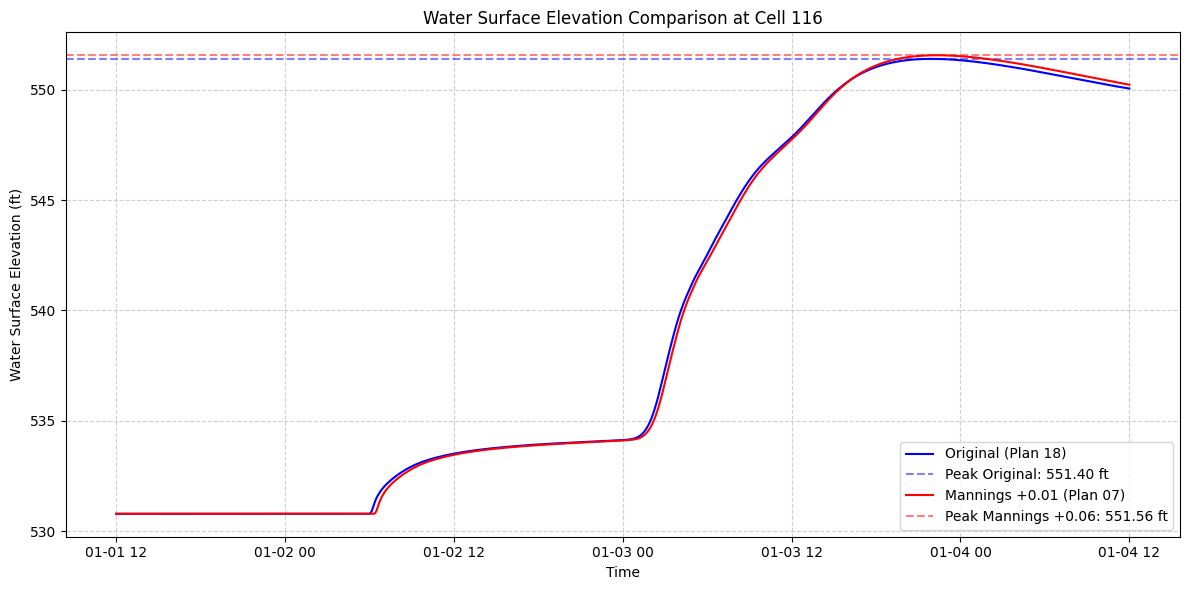

In [30]:
import matplotlib.pyplot as plt

# --- Plot Comparison at Cell ---
print("Generating comparison plot for cell 116...")

# Define the cell ID and variables to compare
target_cell_id = 116

# Initialize figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot data for source plan
source_cell_ts = source_plan_resuls_xr['BaldEagleCr']['Water Surface'].sel(cell_id=target_cell_id)
ax.plot(source_cell_ts.time.values, source_cell_ts.values, 
        label=f"Original (Plan {source_plan})", 
        color='blue', linewidth=1.5)

# Add peak value line for source plan
source_peak = source_cell_ts.max().item()
ax.axhline(source_peak, color='blue', linestyle='--', alpha=0.5,
           label=f'Peak Original: {source_peak:.2f} ft')

# Plot data for revised plan  
revised_cell_ts = revised_plan_resuls_xr['BaldEagleCr']['Water Surface'].sel(cell_id=target_cell_id)
ax.plot(revised_cell_ts.time.values, revised_cell_ts.values,
        label=f"Mannings +0.01 (Plan {revised_plan})",
        color='red', linewidth=1.5)

# Add peak value line for revised plan
revised_peak = revised_cell_ts.max().item()
ax.axhline(revised_peak, color='red', linestyle='--', alpha=0.5,
           label=f'Peak Mannings +0.06: {revised_peak:.2f} ft')

# Customize the plot
ax.set_title(f"Water Surface Elevation Comparison at Cell {target_cell_id}")
ax.set_xlabel("Time") 
ax.set_ylabel("Water Surface Elevation (ft)")
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()
